### Introduction and Part a

We are going to formulate a linear optimization problem to solve it using *Pyomo* library. The problem is as follows:

A car brand has three factories 1, 2 and  3, located at countries 1, 2 and 3 respectively. Each factory produces a different model, let us call them model 1, model 2 and model 3. The three models are sold in countries 1, 2, 3 and 4 (country 4 does not have a factory but does have demand of the models). The aim of the brand is to earn as much money as possible, but taking into account the cost of producing the cars, the price at which they are sold, the demand of the markets and the manufacturing capacity of the factories. The data of the problem are:

* **Factory 1**: produces model 1 at a cost of 15000€ each unit. The maximum manufacturing capacity is 1 million cars. Model 1 cars are sold in country 1 at 18000€, in country 2 at 20000€, in country 3 at 21000€ and in country 4 at 22000€.

* **Factory 2**: produces model 2 at a cost of 22000€ each unit. The maximum manufacturing capacity is 0.5 million cars. Model 2 cars are sold in country 1 at 30000€, in country 2 at 33000€, in country 3 at 29000€ and in country 4 at 31000€.

* **Factory 3**: produces model 3 at a cost of 30000€ each unit. The maximum manufacturing capacity is 10000 cars. Model 3 cars are sold in country 1 at 42000€, in country 2 at 40000€, in country 3 at 41000€ and in country 4 at 44000€.

* **Country 1**: has a maximum demand of 600000 cars. The demand of model 3 is as much 2000 cars.

* **Country 2**: has a maximum demand of 300000 cars. The demand of model 2 is as much 100000 cars.

* **Country 3**: has a maximum demand of 400000 cars.

* **Country 4**: has a maximum demand of 300000 cars. The demand of model 3 is as much 3000 cars.

The formulation of the problem is:

$max{ 18000 x_{11} + 20000 x_{12} + 21000 x_{13} + 22000 x_{14} + 30000 x_{21} + 33000 x_{22} + 29000 x_{23} + 31000 x_{24} + 42000 x_{31} + 40000 x_{32} + 41000 x_{33} + 44000 x_{34} - \left ( x_{11} + x_{12} + x_{13} + x_{14} \right) 15000 - \left ( x_{21} + x_{22} + x_{23} + x_{24} \right) 22000 - \left ( x_{31} + x_{32} + x_{33} + x_{34} \right) 30000}$

s.t.

$x_{11} + x_{12} + x_{13} + x_{14} \leq 1000000$

$x_{21} + x_{22} + x_{33} + x_{34} \leq 500000$

$x_{31} + x_{32} + x_{33} + x_{34} \leq 10000$

$x_{11} + x_{21} + x_{31} \leq 600000$

$x_{12} + x_{22} + x_{32} \leq 300000$

$x_{13} + x_{23} + x_{33} \leq 400000$

$x_{14} + x_{24} + x_{34} \leq 300000$

$x_{31} \leq 2000$

$x_{22} \leq 100000$

$x_{34} \leq 3000$

where $x_{ij}$ states for the number of cars of model $i$ manufactured at factory $i$ to be sent and sold at country $j$. 

### Part b

In [1]:
%%writefile max_return.py

from pyomo.environ import *

#abstract model formulation in pyomo
model = AbstractModel()

#sets of nodes and arcs
model.Nodes = Set()
model.Arcs = Set(dimen=2)

#define for each node the nodes at the end of the arc and viceversa
def NodesOut_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if i == node:
            retval.append(j)
    return retval
model.NodesOut = Set(model.Nodes, initialize=NodesOut_init)

def NodesIn_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if j == node:
            retval.append(i)
    return retval
model.NodesIn = Set(model.Nodes, initialize=NodesIn_init)

#variables
model.Flow = Var(model.Arcs, domain=NonNegativeReals)

#parameters of the problem. profit of the arcs, maximum production of the factories,
#maximum demand of the countries, maximum flow of some arcs
model.FlowProfit = Param(model.Arcs)
model.MaxProduction = Param(model.Nodes)
model.MaxDemand = Param(model.Nodes)
model.FlowMax = Param(model.Arcs)

#objective function
def Obj_rule(model):
    return summation(model.FlowProfit, model.Flow)
model.Obj = Objective(rule=Obj_rule, sense=maximize)

#maximum production constraint
def MaxProductionRule(model, i):
    temp = sum( model.Flow[i,j] for j in model.NodesOut[i] )
    if type(temp) is int:
        return Constraint.Skip
    return temp <= model.MaxProduction[i]
model.MaxProductionCons = Constraint(model.Nodes, rule=MaxProductionRule)

#maximum demand of the countries constraint
def MaxDemandRule(model, j):
    temp = sum( model.Flow[i,j] for i in model.NodesIn[j] )
    if type(temp) is int:
        return Constraint.Skip
    return temp <= model.MaxDemand[j]
model.MaxDemandCons = Constraint(model.Nodes, rule=MaxDemandRule)

#maximum flow of some arcs constraint
def FlowMaxRule(model, i, j):
    return model.Flow[i,j] <= model.FlowMax[i,j]
model.FlowMaxCons = Constraint(model.Arcs, rule=FlowMaxRule)

Overwriting max_return.py


In [2]:
%%writefile max_return.dat

set Nodes := F1 F2 F3 C1 C2 C3 C4;

set Arcs :=
F1 C1
F1 C2
F1 C3
F1 C4
F2 C1
F2 C2
F2 C3
F2 C4
F3 C1
F3 C2
F3 C3
F3 C4
;

param : FlowProfit :=
F1 C1 3000
F1 C2 5000
F1 C3 6000
F1 C4 7000
F2 C1 8000
F2 C2 11000
F2 C3 7000
F2 C4 9000
F3 C1 12000
F3 C2 10000
F3 C3 11000
F3 C4 14000
;

param : MaxProduction :=
F1 1000000
F2 500000
F3 10000
C1 0
C2 0
C3 0
C4 0
;

param : MaxDemand :=
F1 0
F2 0
F3 0
C1 600000
C2 300000
C3 400000
C4 300000
;

param : FlowMax :=
F1 C1 1000000
F1 C2 1000000
F1 C3 1000000
F1 C4 1000000
F2 C1 500000
F2 C2 100000
F2 C3 500000
F2 C4 500000
F3 C1 2000
F3 C2 10000
F3 C3 10000
F3 C4 3000
;

Overwriting max_return.dat


In [3]:
!pyomo solve  max_return.py max_return.dat --solver=glpk --summary 

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.82] Creating model
[    0.85] Applying solver
[    0.91] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: feasible
      Function Value: 10194000000.0
    Solver results file: results.yml

Solution Summary

Model unknown

  Variables:
    Flow : Size=12, Index=Arcs
        Key          : Lower : Value    : Upper : Fixed : Stale : Domain
        ('F1', 'C1') :     0 : 108000.0 :  None : False : False : NonNegativeReals
        ('F1', 'C2') :     0 : 200000.0 :  None : False : False : NonNegativeReals
        ('F1', 'C3') :     0 : 395000.0 :  None : False : False : NonNegativeReals
        ('F1', 'C4') :     0 : 297000.0 :  None : False : False : NonNegativeReals
        ('F2', 'C1') :     0 : 400000.0 :  None : False : False : NonNegativeReals
        ('F2', 'C2') :     0 : 100000.0 :  None : False : False : NonNegativeReals
        ('F2', 'C

From the summary we get that the problem has a unique optimal solution that has been reached. The value of the objective function is 10.194 million of €. The number of cars sent and sold from the factories to all the countries are:

* **From factory 1 to country 1**: 108000
* **From factory 1 to country 2**: 200000
* **From factory 1 to country 3**: 395000
* **From factory 1 to country 4**: 297000
* **From factory 2 to country 1**: 400000
* **From factory 2 to country 2**: 100000
* **From factory 2 to country 3**: 0
* **From factory 2 to country 4**: 0
* **From factory 3 to country 1**: 2000
* **From factory 3 to country 2**: 0
* **From factory 3 to country 3**: 5000
* **From factory 3 to country 4**: 3000

Model 3 produced in factory 3 has the greatest profits. The number of cars sent from factory 3 to countries 1 and 4 are limited by the constraint to 2000 and 3000 respectively, so both constraints are active. Since they are the arcs that produce the greatest profit, it is normal that get the maximum number of cars sent through these arcs. The rest of the cars produced in factory 3 are sent to country 3, because the profit is 1000 € greater compared to being sent to country 2 (which lacks of model 3 cars).
Model 2 produced in factory 2 only is sent only to countries 1 and 2. Country 3 has the lowest profit and although country 4 has the second greatest profit, we have to take into account the profit from model 1 cars. That is why we whould only sell model 2 cars in countries 1 and 2. 100000 model 2 cars are sent from factory 2 to country 2, so again we have an active constraint. Country 2 produces the greatest profit of all the countries for model 2 cars, so it is reasonable to sent there the maximum number allowed. Finally, model 1 cars produced in factory 1 are distributed to all the countries with the goal of getting the greatest return.

Looking at the number of cars produced in each factory, we have that factory 3 manufactures 10000 cars, which meets the maximum production constraint of factory 3. Factory 2 manufactures 500000 cars meeting also the maximum production constraint of factory 2. These is becasue models 3 and 2 have greater return than model 1. Also, factory 1 produces 1 million model 1 cars meeting the constraint of maximum production. If we look back at the demand, adding all the countries we have a maximum demand of 1.6 million and a maximum production of 1.51 million cars, so given that all the model return profits in all the countries, then the three factories are going to manufacture as many cars as possible.

Finally, looking at the countries, we have that countries 2, 3, and 4 meet the constraint of maximum demand because when the three models are combine, these countries return a greater profit than country 1. Country 1 has 90000 users who did not buy a car because the factories did not have capability to increase the production. It is actually the difference of 1.6 million minus 1.51 million explained in the previous paragraph.

### Part c

Let us suppose now that each factory can only send its cars the countries that creates a profit for each car greater than the average of all the countries, or to the countries with a lower profit. For example, in our case we have that model 1 yields a profit of 3000 € per car in country 1, 5000 € per car in country 2, 6000 € per car in country 3 and 7000 € per car in country 4. The mean of the profits is 5250. Thus, model 1 can only be sent to countries 3 and 4 that have a greater profit per car sold, or to countries 1 and 2 that have a lower profit, but model 1 can not be sold in country sets {1,3}, {2,4}, {1,2,3}, etc. 

In the implementation we need to include a new set of binary variables that allow (or do not allow) to send cars from factory x to country y. Also, the last constraint that contains the maximum flow rule is modified in order to satisfy the new restriction.

In [4]:
%%writefile max_return2.py

from pyomo.environ import *

#abstract model formulation in pyomo
model = AbstractModel()

#sets of nodes and arcs
model.Nodes = Set()
model.Arcs = Set(dimen=2)

#define for each node the nodes at the end of the arc and viceversa
def NodesOut_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if i == node:
            retval.append(j)
    return retval
model.NodesOut = Set(model.Nodes, initialize=NodesOut_init)

def NodesIn_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if j == node:
            retval.append(i)
    return retval
model.NodesIn = Set(model.Nodes, initialize=NodesIn_init)

#variables
model.Flow = Var(model.Arcs, domain=NonNegativeReals)

#binary variables
model.FlowRestriction = Var(model.Nodes, domain=Binary)

#parameters of the problem. profit of the arcs, maximum production of the factories,
#maximum demand of the countries, maximum flow of some arcs
model.FlowProfit = Param(model.Arcs)
model.MaxProduction = Param(model.Nodes)
model.MaxDemand = Param(model.Nodes)
model.FlowMax = Param(model.Arcs)

#objective function
def Obj_rule(model):
    return summation(model.FlowProfit, model.Flow)
model.Obj = Objective(rule=Obj_rule, sense=maximize)

#maximum production constraint
def MaxProductionRule(model, i):
    temp = sum( model.Flow[i,j] for j in model.NodesOut[i] )
    if type(temp) is int:
        return Constraint.Skip
    return temp <= model.MaxProduction[i]
model.MaxProductionCons = Constraint(model.Nodes, rule=MaxProductionRule)

#maximum demand of the countries constraint
def MaxDemandRule(model, j):
    temp = sum( model.Flow[i,j] for i in model.NodesIn[j] )
    if type(temp) is int:
        return Constraint.Skip
    return temp <= model.MaxDemand[j]
model.MaxDemandCons = Constraint(model.Nodes, rule=MaxDemandRule)

def FlowMaxRule(model, i, j):
    profit_arc_ij = model.FlowProfit[i,j]
    profit_mean = 0
    count = 0
    for k in model.NodesOut[i]:
        profit_mean += model.FlowProfit[i,k]
        count += 1
    profit_mean /= count
    if profit_arc_ij < profit_mean:
        return model.Flow[i,j] <= model.FlowMax[i,j] * model.FlowRestriction[i]
    else:
        return model.Flow[i,j] <= model.FlowMax[i,j] * (1 - model.FlowRestriction[i])
model.FlowMaxCons = Constraint(model.Arcs, rule=FlowMaxRule)

Overwriting max_return2.py


In [5]:
!pyomo solve  max_return2.py max_return.dat --solver=glpk --summary 

[    0.00] Setting up Pyomo environment
[    0.00] Applying Pyomo preprocessing actions
[    0.82] Creating model
[    0.83] Applying solver
[    0.90] Processing results
    Number of solutions: 1
    Solution Information
      Gap: 0.0
      Status: optimal
      Function Value: 8600000000.0
    Solver results file: results.yml

Solution Summary

Model unknown

  Variables:
    Flow : Size=12, Index=Arcs
        Key          : Lower : Value                : Upper : Fixed : Stale : Domain
        ('F1', 'C1') :     0 :                  0.0 :  None : False : False : NonNegativeReals
        ('F1', 'C2') :     0 :                  0.0 :  None : False : False : NonNegativeReals
        ('F1', 'C3') :     0 :             400000.0 :  None : False : False : NonNegativeReals
        ('F1', 'C4') :     0 :             300000.0 :  None : False : False : NonNegativeReals
        ('F2', 'C1') :     0 :             500000.0 :  None : False : False : NonNegativeReals
        ('F2', 'C2') :     0 :

The summary of the solution shows again that the optimal solution is unique and has been reached. Now the profit is 8.600 million of € which is around a 15% less than the one with no restrictions. Now there are no cars sent from factory 1 to countries 1 and 2 that are the countries with a profit per car lower than the average for all the countries. The binary variable has a value of 0, indicating that the first condition of the code is applied to those countries. We have 400.000 model 1 cars sent to country 3 which is the greatest demand of the country, and 300.000 cars sent to country 4 meeting again the maximum demand of the country. Thus, countries 3 and 4 will not have model 2 and 3 cars. 

Given that, all model 2 cars produced are sent to country 1. They can be sent either to countries 1 and 3 ot to countries 2 and 4. Since there is no longer demand in country 3 all cars are sent to country 1. The value of the binary variable is 1 because this time cars are sent to the group of countries 1 and 3 which has a profit lower than the average. Thus, country 1 receives 500.000 cars (all the production capabilities of model 2) but there is still a demand of 100.000 cars.

Finally, model 3 cars can be sent to countries 2 and 3 or to countries or to countries 1 and 4. It turns out that again is more profitable to sell them in countries 2 and 3, being the binary variable 1. Since country 3 has no demand because of model 1 cars, all model 3 cars are sent to country 2 (10.000 cars).

Regarding the factories, factory 1 manufactures 700.000 cars (the capability is 1 million), factory 2 manufactures 500.000 meeting its maximum production and factory 3 manufactures 10.000 cars meeting again its maximum production.

Regarding the countries, countries 3 and 4 meet the maximum demand with 400.000 cars and 300.000 cars respectively. However, only 500.000 cars are sent to country 1 when the demand is of 600.0000 and only 10.000 cars are sent to country 2 having a demand of 300.000 cars. Thus, we have a country 2 demand is still very large.

### Part d

In this part we are going to add uncertainty in the demand of the countries. The cost of manufacturing the cars and the pricce at which they are sold in the countries are held constant. However, we are going to create a random demand from a multinormal distribution. The mean values of the distributions are the ones used previously, and the standard deviations are 0.01 of the mean values (1%). The correlation is set to 0.8, since it would be expected that if global demand increases (or decreases), then local demand increases (or decreases). We are going to use 1000 scenerios. 
The first stage decision variables are the number of cars each factory has to manufacture, and the second stage decision variables are the number of cars that has to be sent from the factories to each country.
The formulation of the problem is:

In [6]:
%%writefile max_return3.dat

set Nodes := F1 F2 F3 C1 C2 C3 C4;

set Arcs :=
F1 C1
F1 C2
F1 C3
F1 C4
F2 C1
F2 C2
F2 C3
F2 C4
F3 C1
F3 C2
F3 C3
F3 C4
;

param : FlowProfit :=
F1 C1 3000
F1 C2 5000
F1 C3 6000
F1 C4 7000
F2 C1 8000
F2 C2 11000
F2 C3 7000
F2 C4 9000
F3 C1 12000
F3 C2 10000
F3 C3 11000
F3 C4 14000
;

param : MaxProduction :=
F1 1000000
F2 500000
F3 10000
C1 0
C2 0
C3 0
C4 0
;

param : FlowMax :=
F1 C1 1000000
F1 C2 1000000
F1 C3 1000000
F1 C4 1000000
F2 C1 500000
F2 C2 100000
F2 C3 500000
F2 C4 500000
F3 C1 2000
F3 C2 10000
F3 C3 10000
F3 C4 3000
;

Overwriting max_return3.dat


In [7]:
import numpy as np
from pyomo.environ import *
opt = SolverFactory("glpk")
from pyomo.opt import SolverFactory

#for reproducibility
np.random.seed(1)

#number of samples
n_sc=1000

#generate n_sc random samples of the demand of the four countries
means = np.array([600000, 300000, 400000, 300000])
vr = 0.01
stds = np.array([means[0] * vr, means[1] * vr, means[2] * vr, means[3] * vr])
corr = 0.8
covs = [[stds[0]**2, stds[0]*stds[1]*corr, stds[0]*stds[2]*corr, stds[0]*stds[3]*corr],
        [stds[0]*stds[1]*corr, stds[1]**2, stds[1]*stds[2]*corr, stds[1]*stds[3]*corr],
        [stds[0]*stds[2]*corr, stds[1]*stds[2]*corr, stds[2]**2, stds[2]*stds[3]*corr],
        [stds[0]*stds[3]*corr, stds[3]*stds[1]*corr, stds[2]*stds[3]*corr, stds[3]**2]]
MaxDemand = np.random.multivariate_normal(means, covs, n_sc)

#abstract model formulation in pyomo
model = AbstractModel()

#number of scenerios
model.w = RangeSet(1,n_sc)

#sets of nodes and arcs
model.Nodes = Set()
model.Arcs = Set(dimen=2)

#define for each node the nodes at the end of the arc and viceversa
def NodesOut_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if i == node:
            retval.append(j)
    return retval
model.NodesOut = Set(model.Nodes, initialize=NodesOut_init)

def NodesIn_init(model, node):
    retval = []
    for (i,j) in model.Arcs:
        if j == node:
            retval.append(i)
    return retval
model.NodesIn = Set(model.Nodes, initialize=NodesIn_init)

nodesin = ['F1', 'F2', 'F3']
nodesout = ['C1', 'C2', 'C3', 'C4']
#variables
model.Flow = Var(model.w, model.Arcs, domain=NonNegativeReals)

#parameters of the problem. profit of the arcs, maximum production of the factories,
#maximum demand of the countries, maximum flow of some arcs
model.FlowProfit = Param(model.Arcs)
model.MaxProduction = Param(model.Nodes)
model.FlowMax = Param(model.Arcs)

model.Flow.pprint()

def Obj_rule(model):
    of = 0
    nodesin = ['F1', 'F2', 'F3']
    nodesout = ['C1', 'C2', 'C3', 'C4']
    for w in model.w:
        for i in nodesin:
            for j in nodesout:
                of = of + model.FlowProfit[i,j] * model.Flow[w,i,j]
    return(of)
model.Obj = Objective(rule=Obj_rule, sense=maximize)

#maximum production constraint
def MaxProductionRule(model, w, i):
    temp = sum( model.Flow[w,i,j] for j in model.NodesOut[i] )
    if type(temp) is int:
        return Constraint.Skip
    return temp <= model.MaxProduction[i]
model.MaxProductionCons = Constraint(model.w, model.Nodes, rule=MaxProductionRule)

#maximum demand of the countries constraint
def MaxDemandRule(model, w, j):
    temp = sum( model.Flow[w,i,j] for i in model.NodesIn[j] )
    if type(temp) is int:
        return Constraint.Skip
    if j == 'C1':
        return temp <= MaxDemand[w-1,0]
    elif j == 'C2':
        return temp <= MaxDemand[w-1,1]
    elif j == 'C3':
        return temp <= MaxDemand[w-1,2]
    elif j == 'C4':
        return temp <= MaxDemand[w-1,3]
model.MaxDemandCons = Constraint(model.w, model.Nodes, rule=MaxDemandRule)

#maximum flow of some arcs constraint
def FlowMaxRule(model, w, i, j):
    return model.Flow[w,i,j] <= model.FlowMax[i,j]
model.FlowMaxCons = Constraint(model.w, model.Arcs, rule=FlowMaxRule)

Flow : Size=0, Index=Flow_index
    Not constructed


In [8]:
instance = model.create_instance(r'C:\Users\sesig\Documents\GitHub\master_ds_q4_advance_numerical_methods_assignment1\max_return3.dat')
results = opt.solve(instance)
instance_of = instance.Obj()

In [9]:
profit = np.ones(n_sc)
nodesin = ['F1', 'F2', 'F3']
nodesout = ['C1', 'C2', 'C3', 'C4']
for w in range(1,n_sc+1):
    for i in nodesin:
        for j in nodesout:
            profit[w-1] += instance.FlowProfit[i,j] * instance.Flow[w,i,j].value

Once we have run the previous chunks, we can plot a histogram with the expected return of each scenerio. All the profits are almost between 10.000 and 10.275 million of € with mean profit of 10.194 million of €. The mean profit is almost identical to the optimal value obtained in the first part, as it is expected since we have created the demand with a multinormal distribution with mean value the value of the demand of the first part. With these results, we can see how the uncertainty can affect the results of the company at the end of the year.

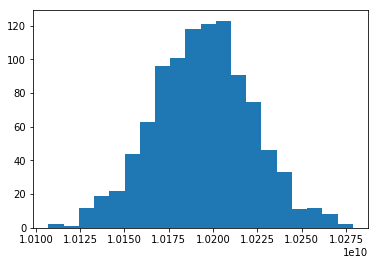

mean return 10194180693.064117


In [11]:
import matplotlib.pyplot as plt
plt.hist(profit, 20)
plt.show()
print('mean return', np.mean(profit))

Finally, the EVPI in € is:

In [13]:
evpi = -10194e6 + np.mean(profit)
print(evpi)

180693.06411743164


And the VSS in € is:

In [17]:
vss = instance_of/n_sc - 10194e6
print(vss)

180692.06412124634
